In [1]:
import os
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pycountry
import warnings
warnings.filterwarnings("ignore")

if not os.path.isdir("notebooks"):
    os.chdir("..")
from plots._helper import (load_ember_data, create_results_dir, 
                                    load_pypsa_network, get_demand_ember, 
                                    get_installed_capacity_ember, get_installed_capacity_pypsa, 
                                    get_generation_capacity_ember, get_generation_capacity_pypsa, 
                                    get_data_EIA, preprocess_eia_data,convert_two_country_code_to_three)

/Users/gbotemi/miniconda3/envs/pypsa-earth-updated/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning: The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 
  warnings.warn(


In [2]:
# Choose the country and the horizon for validation
# Country code should be in ISO 3166-1 alpha-2 format which is 2 country code letters.
# For example, Germany is DE, France is FR, etc.
country_codes = ["CD", "EG", "ET", "LY", "RW", "SO", "SS", "SD", "TZ", "UG", "KE"] #BI, DJ, 
scenario_folder = "eeap"
horizon = 2021

### Load data

In [3]:
ember_data = load_ember_data()

In [4]:
countries_3 = {}

for country in country_codes:
   cc = (convert_two_country_code_to_three(country))
   countries_3[country] = cc

countries_3

{'CD': 'COD',
 'EG': 'EGY',
 'ET': 'ETH',
 'LY': 'LBY',
 'RW': 'RWA',
 'SO': 'SOM',
 'SS': 'SSD',
 'SD': 'SDN',
 'TZ': 'TZA',
 'UG': 'UGA',
 'KE': 'KEN'}

In [5]:
# Load PyPSA network
# Note: you can also load the network directly using """network = pypsa.Network(network_path)"""
network = load_pypsa_network(scenario_folder)

# Load EIA data
EIA_demand_path = os.path.join(os.getcwd(), "data", "EIA_demands.csv")
EIA_installed_capacities_path = os.path.join(os.getcwd(), "data", "EIA_installed_capacities.csv")
EIA_generation_path = os.path.join(os.getcwd(), "data", "EIA_electricity_generation.csv")

# three_country_code = convert_two_country_code_to_three(country_code)
create_results_dir()

INFO:pypsa.io:Imported network elec_s_50_ec_lcopt_Co2L-24H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


### Network Plot


(<matplotlib.collections.PatchCollection at 0x30f604430>,
 <matplotlib.collections.LineCollection at 0x30fbd6b00>)

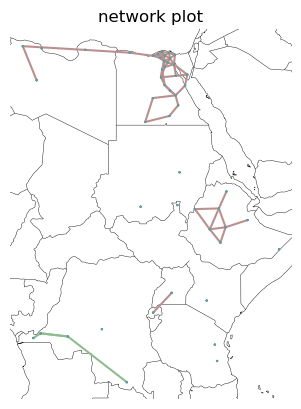

In [6]:
network.plot(title=f"network plot")

### Demand

In [7]:
demand_ember = {}

for country2, country3 in countries_3.items():
    demand = get_demand_ember(ember_data, country3, horizon)
    demand_ember[country2] = demand

total_demand_ember = sum(demand_ember.values()).round(2)

In [8]:
eia_demand = {}

for country in country_codes:
    demand = get_data_EIA(EIA_demand_path, country, horizon).iloc[0,1]
    eia_demand[country] = demand.round(2)

total_eia_demand = sum(eia_demand.values()).round(2)

In [9]:
pypsa_demand = {}
for country_name in country_codes:
    bus_idx = network.buses.query(f"country == '{country_name}' & carrier == 'AC'").index
    py_demand = network.loads_t.p_set.loc[:, bus_idx].multiply(
        network.snapshot_weightings.objective, axis=0).sum().sum() / 1e6
    if py_demand:
        pypsa_demand[country_name] = py_demand.round(2)

total_pypsa_demand = sum(pypsa_demand.values()).round(2)

In [10]:
print(f"Demand from PyPSA: {total_pypsa_demand} \nDemand from Ember: {total_demand_ember} \nDemand from EIA: {total_eia_demand}")

Demand from PyPSA: 506.09 
Demand from Ember: 312.88 
Demand from EIA: 257.6


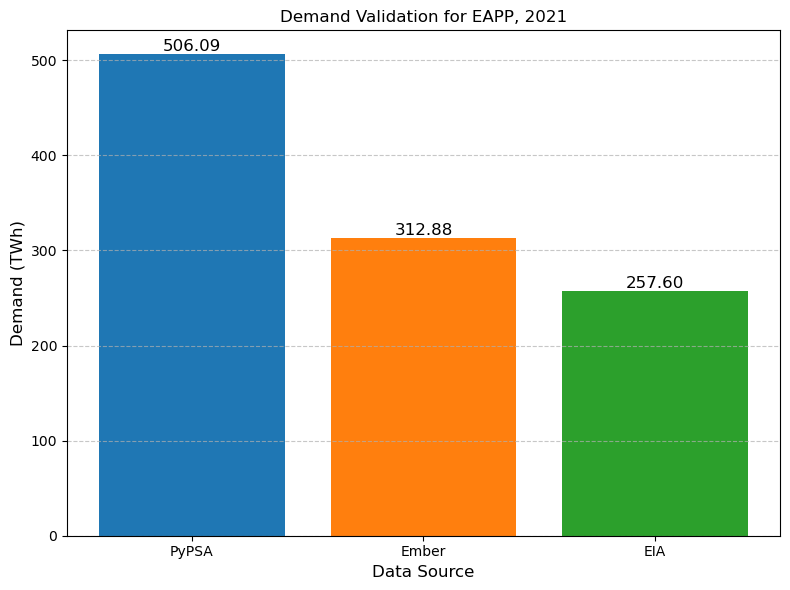

In [11]:
plt.figure(figsize=(8, 6))  # Set figure size
bars = plt.bar(["PyPSA", "Ember", "EIA"], 
               [total_pypsa_demand, total_demand_ember, total_eia_demand], 
               color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title(f"Demand Validation for EAPP, {horizon}")
plt.ylabel("Demand (TWh)", fontsize=12)
plt.xlabel("Data Source", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.savefig(f"results/plots/demand_validation_EAPP.png")
plt.show()

In [12]:
cc_wise_demand = pd.DataFrame([pypsa_demand, demand_ember, eia_demand], index=["PyPSA", "Ember", "EIA"]).T

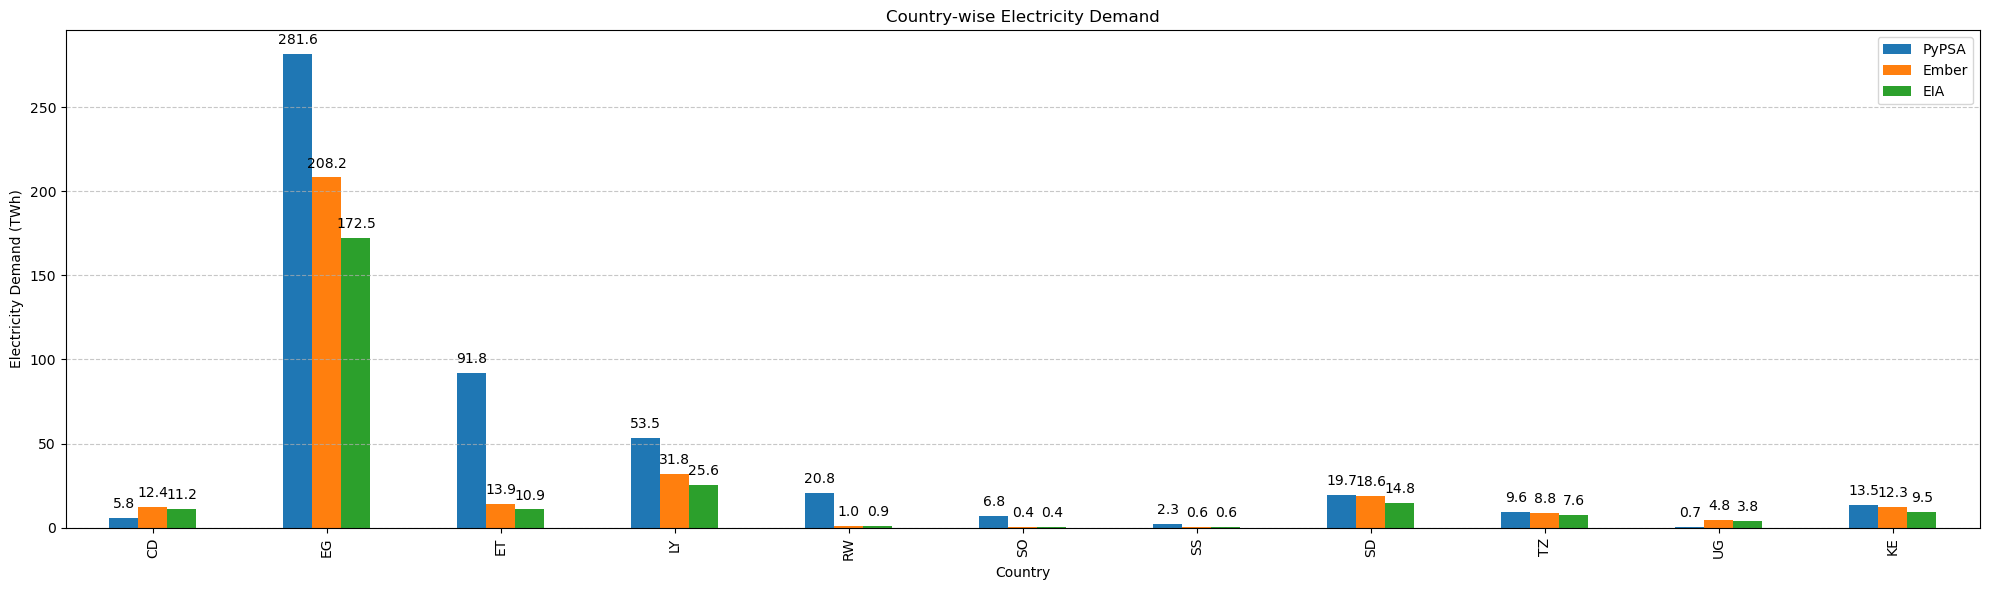

In [13]:
ax = cc_wise_demand.plot(kind='bar', figsize=(20, 6))
plt.title("Country-wise Electricity Demand")
plt.xlabel("Country")
plt.ylabel("Electricity Demand (TWh)")

for p in ax.patches:
    ax.annotate(f'{p.get_height():,.1f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"results/plots/country_wise_demand_validation_EAPP.png")
plt.show()

### Installed Capacity

In [14]:
total_capacity_ember = pd.DataFrame()

for country2, country3 in countries_3.items():
    cap = get_installed_capacity_ember(ember_data, country3, horizon)
    cap.columns = [f"{country2}"]
    total_capacity_ember = (total_capacity_ember
                            .merge(cap, left_index=True, right_index=True, how="outer"))
    

In [15]:
total_EIA_capacity = pd.DataFrame()

for country in country_codes:
    eia_cap = preprocess_eia_data(get_data_EIA(EIA_installed_capacities_path, country, horizon))
    eia_cap.columns = [f"{country}"]
    total_EIA_capacity = (total_EIA_capacity
                          .merge(eia_cap, left_index=True, right_index=True, how="outer"))
    

In [16]:
pypsa_installed_capacity = pd.DataFrame()

for country in country_codes:
    py_cap = get_installed_capacity_pypsa(network, f"{country}")
    py_cap.columns = [f"{country}"]
    pypsa_installed_capacity = (pypsa_installed_capacity
                                .merge(py_cap, left_index=True, right_index=True, how="outer"))
    

In [17]:
cc_installed_capacity_df = pd.concat([pypsa_installed_capacity.sum(), total_capacity_ember.sum(), total_EIA_capacity.sum()], axis=1).fillna(0)
cc_installed_capacity_df.columns = ["PyPSA", "Ember", "EIA"]

In [18]:
carrier_installed_capacity_df = pd.concat([pypsa_installed_capacity.sum(axis=1), total_capacity_ember.sum(axis=1), total_EIA_capacity.sum(axis=1)], axis=1).fillna(0)
carrier_installed_capacity_df.columns = ["PyPSA", "Ember", "EIA"]

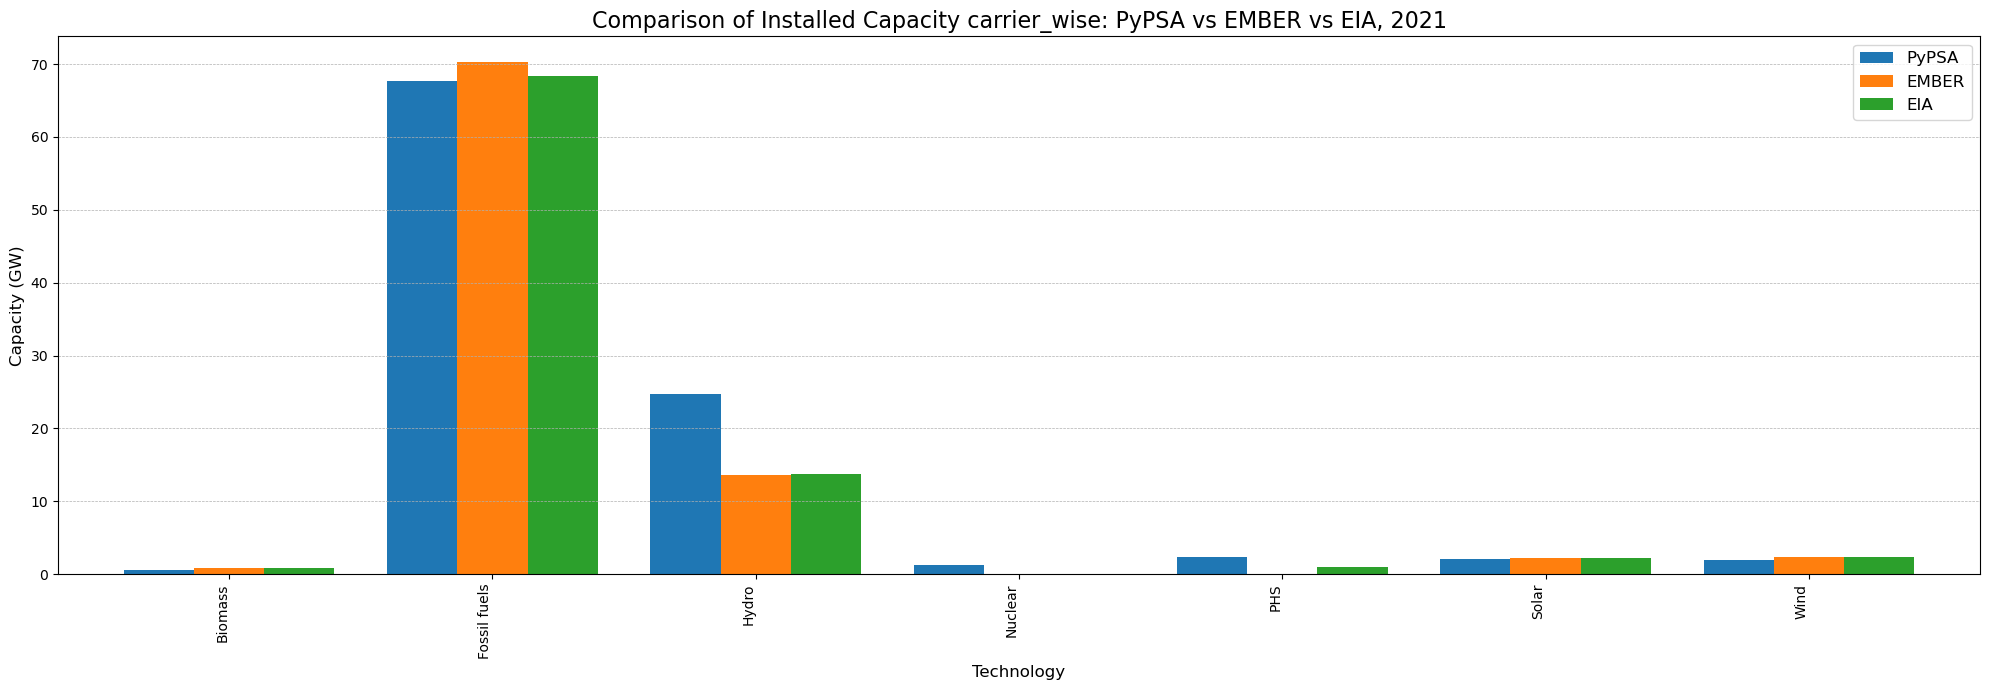

In [19]:
ax = carrier_installed_capacity_df.plot(kind="bar", figsize=(20, 7), width=0.8)
plt.title(f"Comparison of Installed Capacity carrier_wise: PyPSA vs EMBER vs EIA, {horizon}", fontsize=16)
plt.xlabel("Technology", fontsize=12)
plt.ylabel("Capacity (GW)", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), ha="right", fontsize=10)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.legend(["PyPSA", "EMBER", "EIA"], loc="upper right", fontsize=12)
plt.tight_layout()
plt.savefig(f"results/plots/carrier_wise_capacity_validation_EAPP.png")
plt.show()

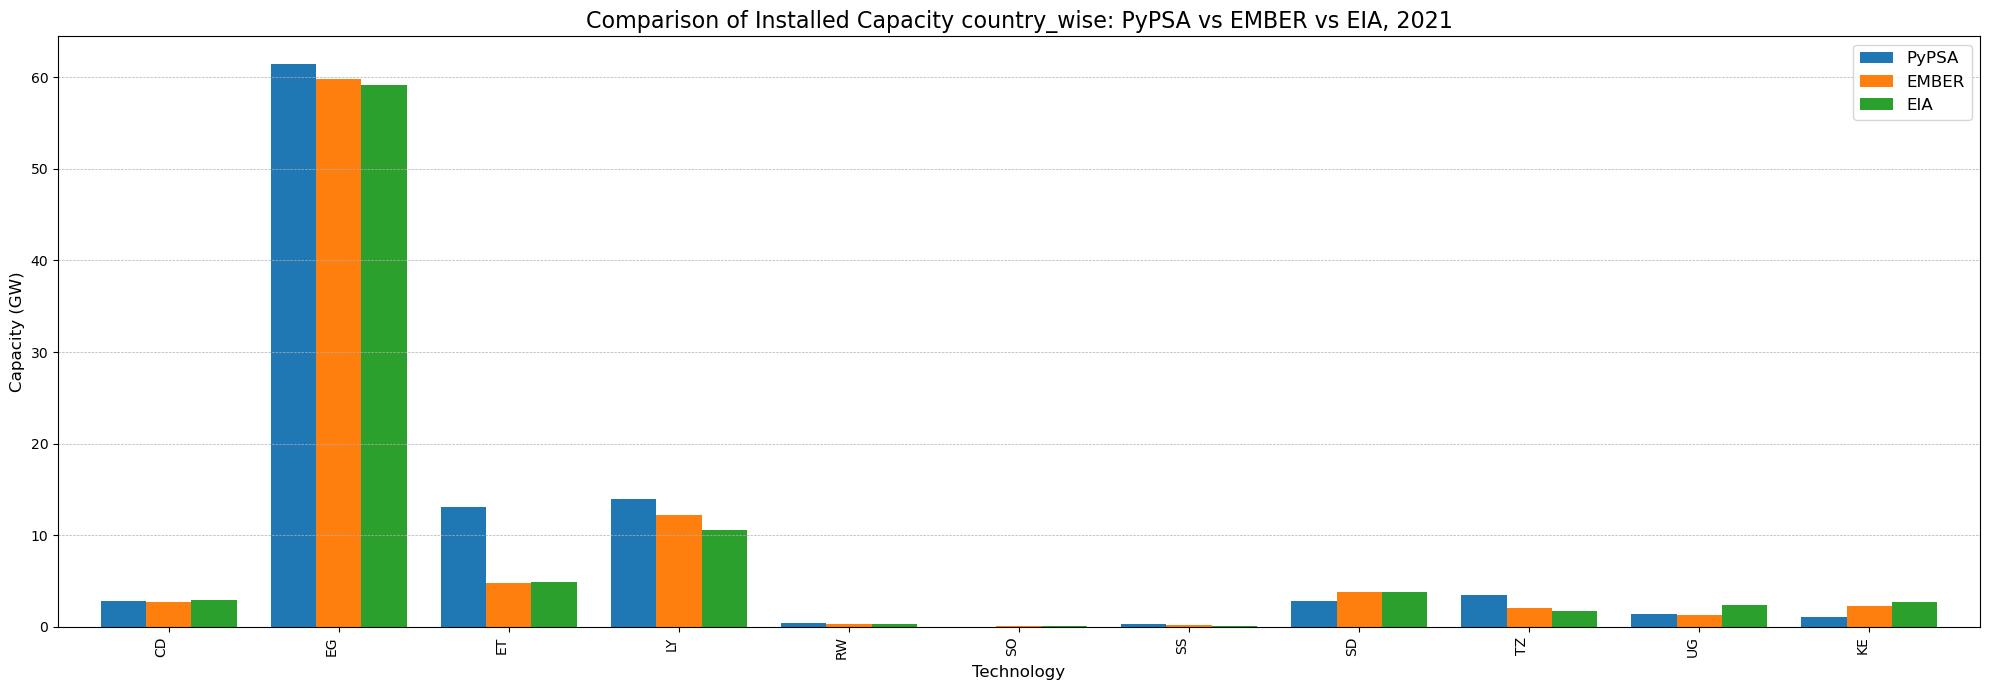

In [20]:
ax = cc_installed_capacity_df.plot(kind="bar", figsize=(20, 7), width=0.8)
plt.title(f"Comparison of Installed Capacity country_wise: PyPSA vs EMBER vs EIA, {horizon}", fontsize=16)
plt.xlabel("Technology", fontsize=12)
plt.ylabel("Capacity (GW)", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), ha="right", fontsize=10)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.legend(["PyPSA", "EMBER", "EIA"], loc="upper right", fontsize=12)
plt.tight_layout()
plt.savefig(f"results/plots/country_wise_capacity_validation_EAPP.png")
plt.show()

### Generation

In [21]:
total_generation_ember = pd.DataFrame()

for country2, country3 in countries_3.items():
    cap = get_generation_capacity_ember(ember_data, country3, horizon)
    cap.columns = [f"{country2}"]
    total_generation_ember = (total_generation_ember
                            .merge(cap, left_index=True, right_index=True, how="outer"))
    

In [22]:
total_EIA_generation = pd.DataFrame()

for country in country_codes:
    eia_cap = preprocess_eia_data(get_data_EIA(EIA_generation_path, country, horizon))
    eia_cap.columns = [f"{country}"]
    total_EIA_generation = (total_EIA_generation
                          .merge(eia_cap, left_index=True, right_index=True, how="outer"))
    

In [23]:
pypsa_generation = pd.DataFrame()

for country in country_codes:
    py_generation = get_generation_capacity_pypsa(network, f"{country}")
    py_generation.columns = [f"{country}"]
    pypsa_generation = (pypsa_generation
                                .merge(py_generation, left_index=True, right_index=True, how="outer"))
    

In [24]:
cc_generation_df = pd.concat([pypsa_generation.sum(), total_generation_ember.sum(), total_EIA_generation.sum()], axis=1).fillna(0)
cc_generation_df.columns = ["PyPSA", "Ember", "EIA"]

In [25]:
carrier_generation_df = pd.concat([pypsa_generation.sum(axis=1), total_generation_ember.sum(axis=1), total_EIA_generation.sum(axis=1)], axis=1).fillna(0)
carrier_generation_df.columns = ["PyPSA", "Ember", "EIA"]

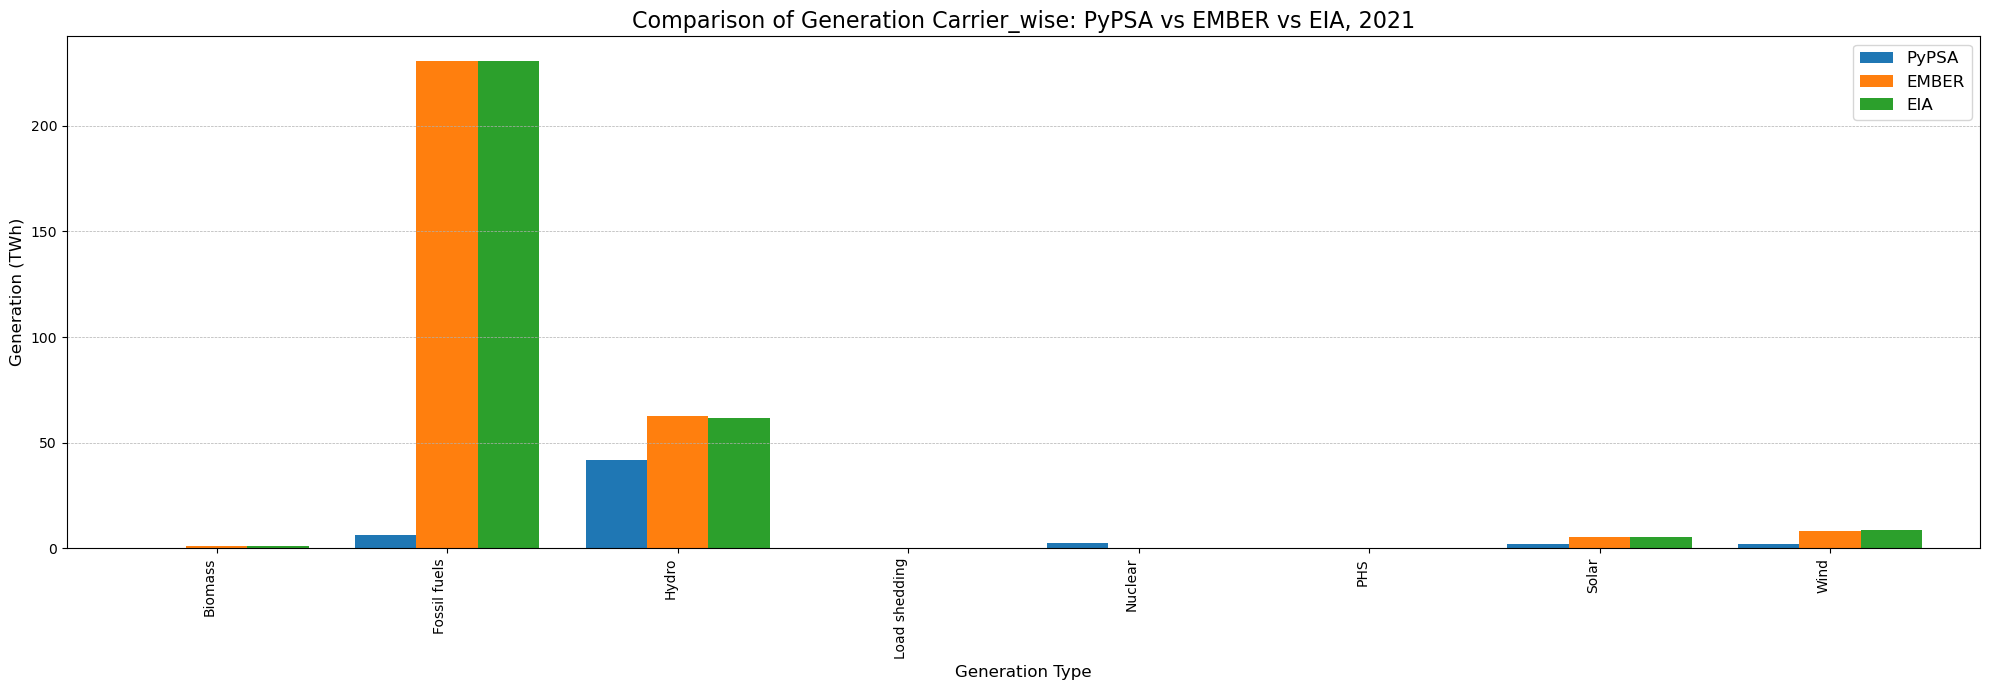

In [26]:
ax = carrier_generation_df.plot(kind="bar", figsize=(20, 7), width=0.8)
plt.title(f"Comparison of Generation Carrier_wise: PyPSA vs EMBER vs EIA, {horizon}", fontsize=16)
plt.xlabel("Generation Type", fontsize=12)
plt.ylabel("Generation (TWh)", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), ha="right", fontsize=10)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.legend(["PyPSA", "EMBER", "EIA"], loc="upper right", fontsize=12)
plt.tight_layout()
plt.savefig(f"results/plots/carrier_wise_generation_validation_EAPP.png")
plt.show()

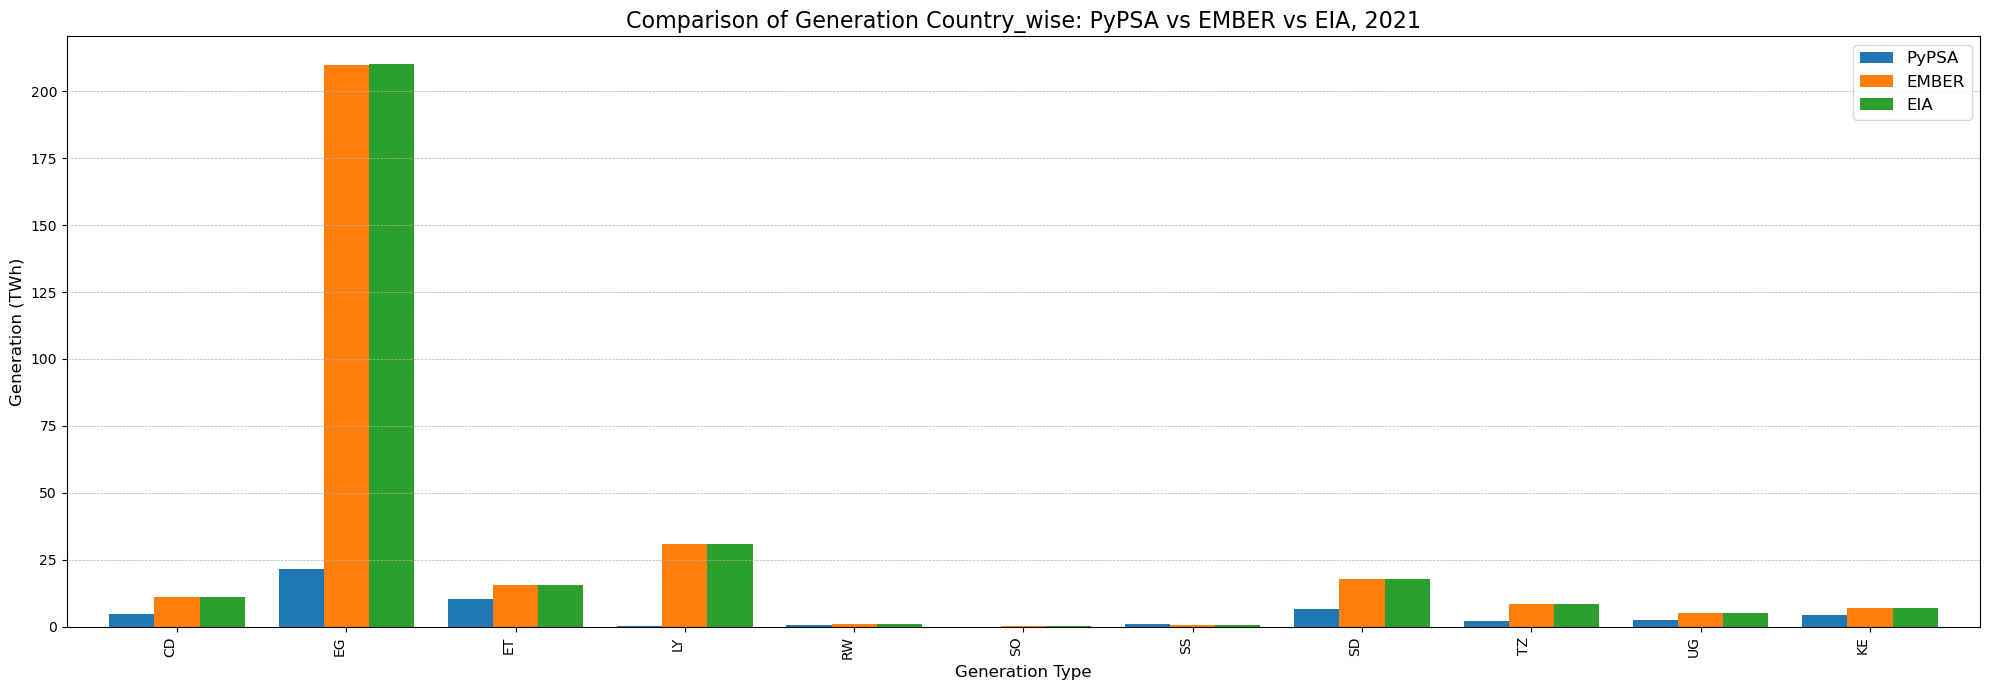

In [27]:
ax = cc_generation_df.plot(kind="bar", figsize=(20, 7), width=0.8)
plt.title(f"Comparison of Generation Country_wise: PyPSA vs EMBER vs EIA, {horizon}", fontsize=16)
plt.xlabel("Generation Type", fontsize=12)
plt.ylabel("Generation (TWh)", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), ha="right", fontsize=10)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.legend(["PyPSA", "EMBER", "EIA"], loc="upper right", fontsize=12)
plt.tight_layout()
plt.savefig(f"results/plots/country_wise_generation_validation_EAPP.png")
plt.show()